In [6]:

%%time


import time
import datetime as dt
import os

import pandas
import pandas as pd
import praw
from praw.models import ListingGenerator
from tqdm import tqdm

from common.captioning.caption import BlipCaption
from common.schemas.pyarrow_schema import schema
from common.storage.azure_file_storage import AzureFileStorageAdapter

tqdm.pandas(desc="Progress")

file_system = AzureFileStorageAdapter('data').get_file_storage()

from common.data_frame_functions.functions import Functions

functions: Functions = Functions()

CPU times: total: 2.89 s
Wall time: 3.01 s


In [7]:
%%time

curated_data = pandas.read_parquet("data/parquet/back.parquet", engine="pyarrow", filesystem=file_system)

curated_data.set_index("id", inplace=True, drop=False)

filtered = curated_data.loc[curated_data["accept"] == True, schema.names]

filtered.dropna(inplace=True)

display(filtered.shape)

display(filtered)

(15714, 15)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
id,,,,,,,,,,,,,,,
1013bdt,1013bdt,AmIhotAF,RaulDea9286,36F - ITALIAN,arafed image of a woman in a bikini top,7c0d158cba8654ef1c635cbc5471d597,/r/AmIhotAF/comments/1013bdt/36f_italian/,https://i.redd.it/bg0wwdlt5k9a1.jpg,1013bdt.jpg,data/image/1013bdt.jpg,SexyDiffusion,True,True,True,[]
105mekt,105mekt,AmIhotAF,lindaniz,interesting in good forward relationship (f24),a close up of a woman with red hair and a whit...,ba4a0962cca2266a741e1e1700589c04,/r/AmIhotAF/comments/105mekt/interesting_in_go...,https://i.redd.it/4avjshsz8naa1.jpg,105mekt.jpg,data/image/105mekt.jpg,SexyDiffusion,True,True,True,[]
105qvgl,105qvgl,AmIhotAF,CaitVLove11,Laughing is my favorite 😆,a woman in a blue tank top and shorts is smili...,27bfe82c37314a0bcf02ab72eaf3a9e5,/r/AmIhotAF/comments/105qvgl/laughing_is_my_fa...,https://i.redd.it/2pulzr0lxmaa1.jpg,105qvgl.jpg,data/image/105qvgl.jpg,SexyDiffusion,True,True,True,[]
105rpcj,105rpcj,AmIhotAF,Flashy-Desk1858,[f22] What do you think when you see me?,a woman in a blue bikini top and a blue bra top,329eb42b8267fa1cc2980da8e48bcef1,/r/AmIhotAF/comments/105rpcj/f22_what_do_you_t...,https://i.redd.it/rz68pf934naa1.jpg,105rpcj.jpg,data/image/105rpcj.jpg,SexyDiffusion,True,True,True,[]
105styc,105styc,AmIhotAF,Gizzygirl127,Low key… still bangable?,smiling woman sitting on couch with remote con...,6d555943be4fbc21ff92417c6f582298,/r/AmIhotAF/comments/105styc/low_key_still_ban...,https://i.redd.it/aiaxxoz9uoaa1.jpg,105styc.jpg,data/image/105styc.jpg,SexyDiffusion,True,True,True,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11wtvwm,11wtvwm,realasians,sooanyways,Cute Brunch Date,smiling woman sitting at a table with a cell p...,9c14d5dad845ca9d82b7c47f390eca8c,/r/realasians/comments/11wtvwm/cute_brunch_date/,https://i.redd.it/cfa8bbbyqzoa1.jpg,11wtvwm.jpg,data/image/11wtvwm.jpg,SexyAsianDiffusion,True,True,True,[]
11wplnb,11wplnb,realasians,Majestic_Painter8660,Pretty asian girl,asian woman in a black dress sitting at a tabl...,1029f97565bda3fad4d21bc60fdf40fa,/r/realasians/comments/11wplnb/pretty_asian_girl/,https://i.redd.it/osae0fvujska1.jpg,11wplnb.jpg,data/image/11wplnb.jpg,SexyAsianDiffusion,True,True,True,[]
11wpl8l,11wpl8l,realasians,Majestic_Painter8660,Spillage,asian woman in a short skirted top and a white...,142c10bb775016ba368b6b06b1dd0374,/r/realasians/comments/11wpl8l/spillage/,https://i.redd.it/tzdu2fssjska1.jpg,11wpl8l.jpg,data/image/11wpl8l.jpg,SexyAsianDiffusion,True,True,True,[]


CPU times: total: 469 ms
Wall time: 1.09 s


In [8]:
%%time

sources = [
	{"name": "CityDiffusion", "data": ["CityPorn"]},
	{"name": "NatureDiffusion", "data": ["EarthPorn"]},
	{"name": "CosmicDiffusion", "data": ["spaceporn"]},
	{"name": "ITAPDiffusion", "data": ["itookapicture"]},
	{"name": "MemeDiffusion", "data": ["memes"]},
	{"name": "TTTDiffusion", "data": ["trippinthroughtime"]},
	{"name": "WallStreetDiffusion", "data": ["wallstreetbets"]},
	{"name": "SexyDiffusion", "data": ["selfies", "Amicute", "amihot", "AmIhotAF", "HotGirlNextDoor", "sexygirls", "PrettyGirls", "gentlemanboners", "hotofficegirls", "tightdresses", "DLAH"]},
	{"name": "FatSquirrelDiffusion", "data": ["fatsquirrelhate"]},
	{"name": "CelebrityDiffusion", "data": ["celebrities"]},
	{"name": "OldLadyDiffusion", "data": ["oldladiesbakingpies"]},
	{"name": "SWFPetite", "data": ["sfwpetite"]},
	{"name": "SFWMilfs", "data": ["cougars_and_milfs_sfw"]},
	{"name": "RedHeadDiffusion", "data": ["SFWRedheads"]},
	{"name": "NextDoorGirlsDiffusion", "data": ["SFWNextDoorGirls"]},
	{"name": "SexyAsianDiffusion", "data": ["realasians", "KoreanHotties", "prettyasiangirls", "AsianOfficeLady", "AsianInvasion"]},
	{"name": "MildlyPenisDiffusion", "data": ["mildlypenis"]},
	{"name": "CandleDiffusion", "data": ["bathandbodyworks"] },
]
sources_df = pd.DataFrame.from_records(sources)

CPU times: total: 0 ns
Wall time: 0 ns


In [9]:
filtered['model'] = filtered.apply(lambda x: functions.add_source(x, sources), axis=1)
foo = filtered.loc[filtered['model'] != ""]
foo.dropna()
filtered = foo
display(filtered)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
id,,,,,,,,,,,,,,,
1013bdt,1013bdt,AmIhotAF,RaulDea9286,36F - ITALIAN,arafed image of a woman in a bikini top,7c0d158cba8654ef1c635cbc5471d597,/r/AmIhotAF/comments/1013bdt/36f_italian/,https://i.redd.it/bg0wwdlt5k9a1.jpg,1013bdt.jpg,data/image/1013bdt.jpg,SexyDiffusion,True,True,True,[]
105mekt,105mekt,AmIhotAF,lindaniz,interesting in good forward relationship (f24),a close up of a woman with red hair and a whit...,ba4a0962cca2266a741e1e1700589c04,/r/AmIhotAF/comments/105mekt/interesting_in_go...,https://i.redd.it/4avjshsz8naa1.jpg,105mekt.jpg,data/image/105mekt.jpg,SexyDiffusion,True,True,True,[]
105qvgl,105qvgl,AmIhotAF,CaitVLove11,Laughing is my favorite 😆,a woman in a blue tank top and shorts is smili...,27bfe82c37314a0bcf02ab72eaf3a9e5,/r/AmIhotAF/comments/105qvgl/laughing_is_my_fa...,https://i.redd.it/2pulzr0lxmaa1.jpg,105qvgl.jpg,data/image/105qvgl.jpg,SexyDiffusion,True,True,True,[]
105rpcj,105rpcj,AmIhotAF,Flashy-Desk1858,[f22] What do you think when you see me?,a woman in a blue bikini top and a blue bra top,329eb42b8267fa1cc2980da8e48bcef1,/r/AmIhotAF/comments/105rpcj/f22_what_do_you_t...,https://i.redd.it/rz68pf934naa1.jpg,105rpcj.jpg,data/image/105rpcj.jpg,SexyDiffusion,True,True,True,[]
105styc,105styc,AmIhotAF,Gizzygirl127,Low key… still bangable?,smiling woman sitting on couch with remote con...,6d555943be4fbc21ff92417c6f582298,/r/AmIhotAF/comments/105styc/low_key_still_ban...,https://i.redd.it/aiaxxoz9uoaa1.jpg,105styc.jpg,data/image/105styc.jpg,SexyDiffusion,True,True,True,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11wtvwm,11wtvwm,realasians,sooanyways,Cute Brunch Date,smiling woman sitting at a table with a cell p...,9c14d5dad845ca9d82b7c47f390eca8c,/r/realasians/comments/11wtvwm/cute_brunch_date/,https://i.redd.it/cfa8bbbyqzoa1.jpg,11wtvwm.jpg,data/image/11wtvwm.jpg,SexyAsianDiffusion,True,True,True,[]
11wplnb,11wplnb,realasians,Majestic_Painter8660,Pretty asian girl,asian woman in a black dress sitting at a tabl...,1029f97565bda3fad4d21bc60fdf40fa,/r/realasians/comments/11wplnb/pretty_asian_girl/,https://i.redd.it/osae0fvujska1.jpg,11wplnb.jpg,data/image/11wplnb.jpg,SexyAsianDiffusion,True,True,True,[]
11wpl8l,11wpl8l,realasians,Majestic_Painter8660,Spillage,asian woman in a short skirted top and a white...,142c10bb775016ba368b6b06b1dd0374,/r/realasians/comments/11wpl8l/spillage/,https://i.redd.it/tzdu2fssjska1.jpg,11wpl8l.jpg,data/image/11wpl8l.jpg,SexyAsianDiffusion,True,True,True,[]


CPU times: total: 406 ms
Wall time: 415 ms


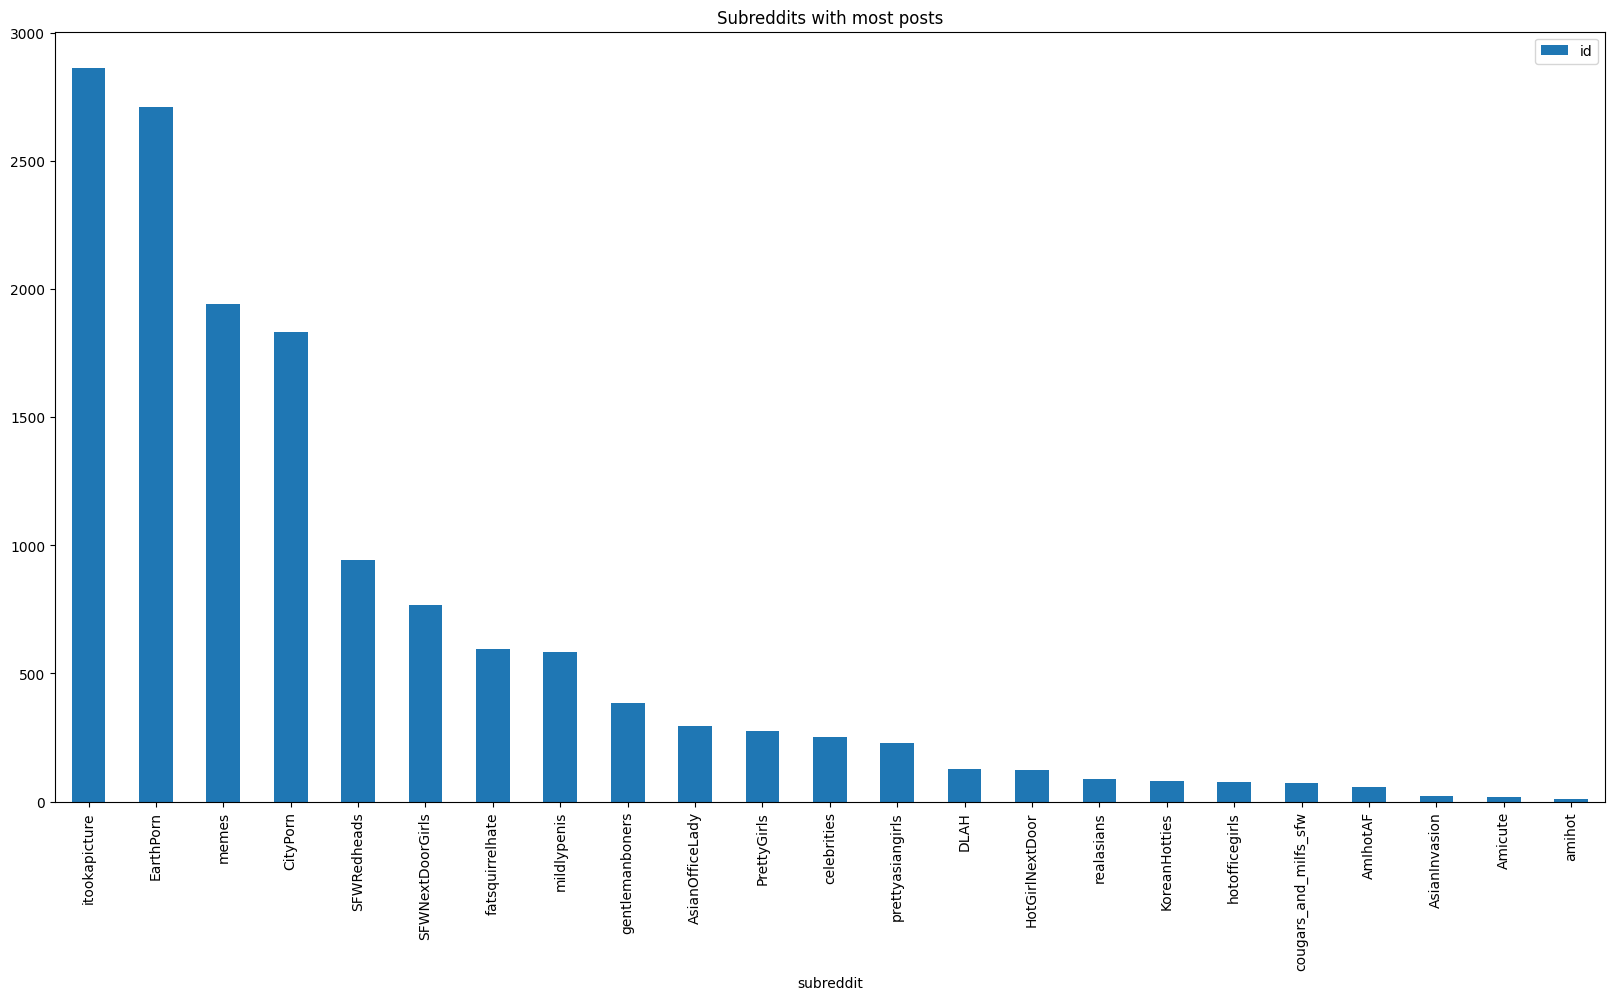

In [10]:
%%time

group = filtered[["id", "subreddit"]].groupby("subreddit").count().sort_values(by="id", ascending=False)
plot = group.plot.bar(figsize=(20, 10), title="Subreddits with most posts", legend=True)

CPU times: total: 62.5 ms
Wall time: 62.5 ms


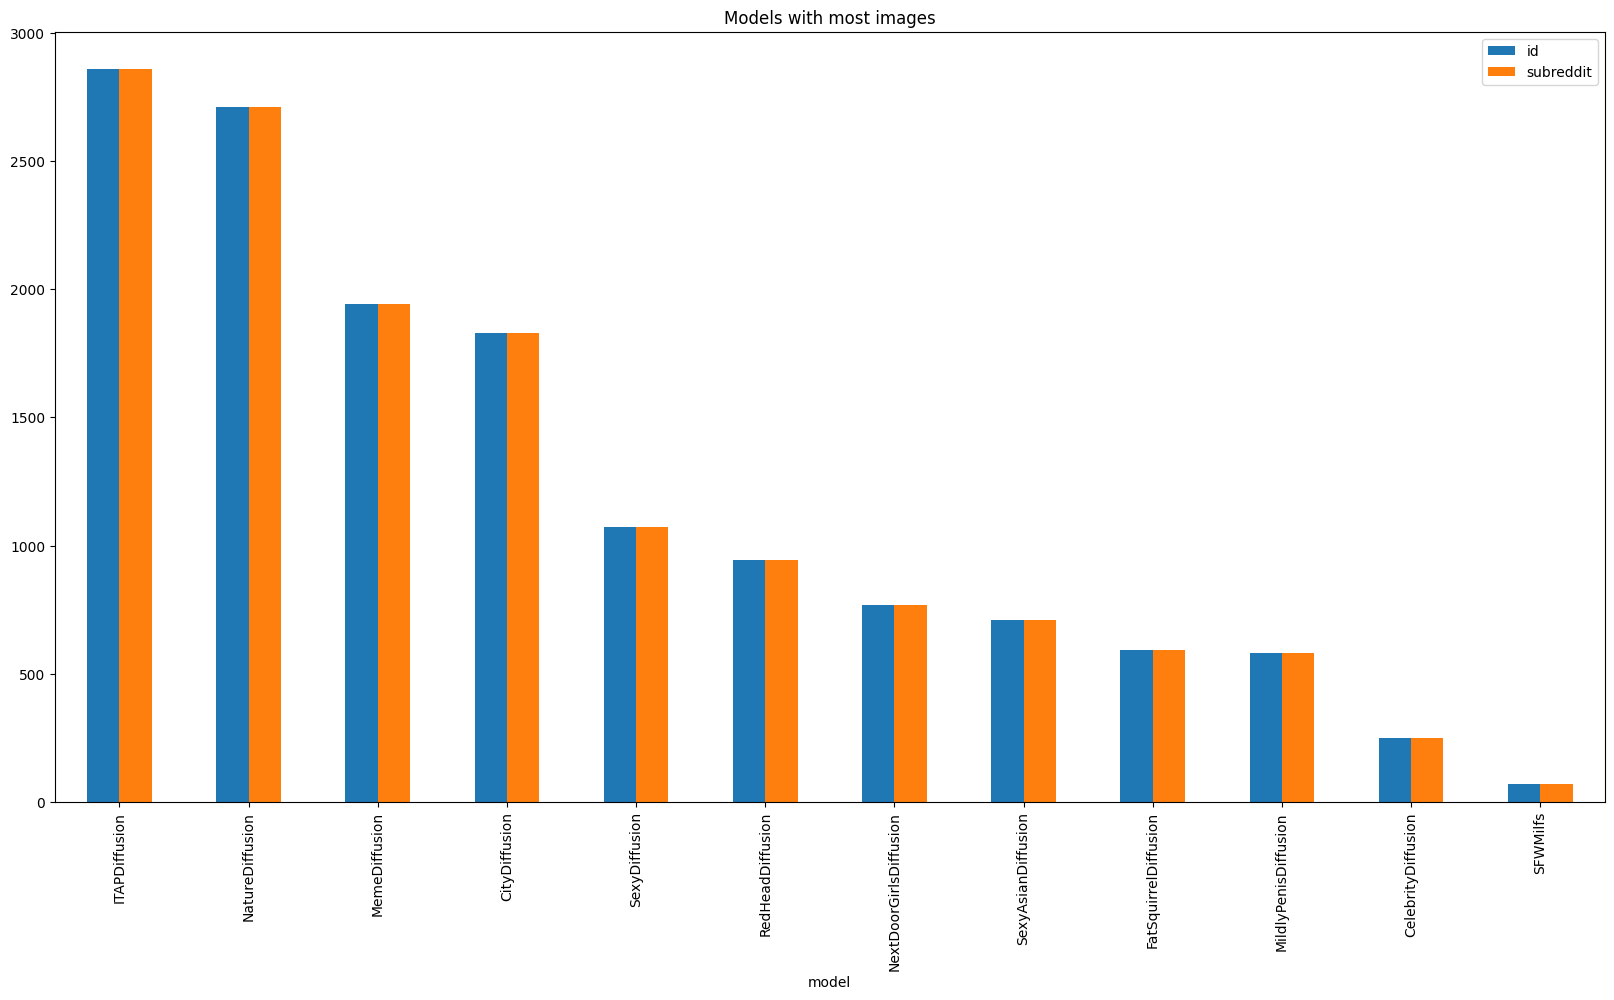

In [11]:
%%time

group = filtered[["id", "model", "subreddit"]].groupby(["model"]).count().sort_values(by="id", ascending=False)
plot = group.plot.bar(figsize=(20, 10), title="Models with most images", legend=True)

In [19]:
%%time

images = file_system.ls("data/image")

bar = filtered.loc[(filtered["model"] == "SexyDiffusion") | (filtered["model"] == "SexyAsianDiffusion") | (filtered['model'] == "NextDoorGirlDiffusion") | (filtered['model'] == 'RedHeadDiffusion')]
bar.dropna(inplace=True)
display(bar.shape)
display(bar)

<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(1785, 15)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,model,exists,curated,accept,tags
id,,,,,,,,,,,,,,,
1013bdt,1013bdt,AmIhotAF,RaulDea9286,36F - ITALIAN,arafed image of a woman in a bikini top,7c0d158cba8654ef1c635cbc5471d597,/r/AmIhotAF/comments/1013bdt/36f_italian/,https://i.redd.it/bg0wwdlt5k9a1.jpg,1013bdt.jpg,data/image/1013bdt.jpg,SexyDiffusion,True,True,True,[]
105mekt,105mekt,AmIhotAF,lindaniz,interesting in good forward relationship (f24),a close up of a woman with red hair and a whit...,ba4a0962cca2266a741e1e1700589c04,/r/AmIhotAF/comments/105mekt/interesting_in_go...,https://i.redd.it/4avjshsz8naa1.jpg,105mekt.jpg,data/image/105mekt.jpg,SexyDiffusion,True,True,True,[]
105qvgl,105qvgl,AmIhotAF,CaitVLove11,Laughing is my favorite 😆,a woman in a blue tank top and shorts is smili...,27bfe82c37314a0bcf02ab72eaf3a9e5,/r/AmIhotAF/comments/105qvgl/laughing_is_my_fa...,https://i.redd.it/2pulzr0lxmaa1.jpg,105qvgl.jpg,data/image/105qvgl.jpg,SexyDiffusion,True,True,True,[]
105rpcj,105rpcj,AmIhotAF,Flashy-Desk1858,[f22] What do you think when you see me?,a woman in a blue bikini top and a blue bra top,329eb42b8267fa1cc2980da8e48bcef1,/r/AmIhotAF/comments/105rpcj/f22_what_do_you_t...,https://i.redd.it/rz68pf934naa1.jpg,105rpcj.jpg,data/image/105rpcj.jpg,SexyDiffusion,True,True,True,[]
105styc,105styc,AmIhotAF,Gizzygirl127,Low key… still bangable?,smiling woman sitting on couch with remote con...,6d555943be4fbc21ff92417c6f582298,/r/AmIhotAF/comments/105styc/low_key_still_ban...,https://i.redd.it/aiaxxoz9uoaa1.jpg,105styc.jpg,data/image/105styc.jpg,SexyDiffusion,True,True,True,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11wtvwm,11wtvwm,realasians,sooanyways,Cute Brunch Date,smiling woman sitting at a table with a cell p...,9c14d5dad845ca9d82b7c47f390eca8c,/r/realasians/comments/11wtvwm/cute_brunch_date/,https://i.redd.it/cfa8bbbyqzoa1.jpg,11wtvwm.jpg,data/image/11wtvwm.jpg,SexyAsianDiffusion,True,True,True,[]
11wplnb,11wplnb,realasians,Majestic_Painter8660,Pretty asian girl,asian woman in a black dress sitting at a tabl...,1029f97565bda3fad4d21bc60fdf40fa,/r/realasians/comments/11wplnb/pretty_asian_girl/,https://i.redd.it/osae0fvujska1.jpg,11wplnb.jpg,data/image/11wplnb.jpg,SexyAsianDiffusion,True,True,True,[]
11wpl8l,11wpl8l,realasians,Majestic_Painter8660,Spillage,asian woman in a short skirted top and a white...,142c10bb775016ba368b6b06b1dd0374,/r/realasians/comments/11wpl8l/spillage/,https://i.redd.it/tzdu2fssjska1.jpg,11wpl8l.jpg,data/image/11wpl8l.jpg,SexyAsianDiffusion,True,True,True,[]


CPU times: total: 78.1 ms
Wall time: 83.4 ms
